In [7]:
import sys
sys.path.append("../src/")

import torch
import numpy as np
import matplotlib.pyplot as plt
from models import DummyNet
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.manifold import TSNE

%matplotlib inline


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
checkpoint = torch.load("../checkpoints/checkpoint_500.pkl", map_location=device)
model = DummyNet()
model = torch.nn.DataParallel(model)
model = model.to(device)
model.load_state_dict(checkpoint["model"], strict=False)


<All keys matched successfully>

In [9]:
tr = transforms.Compose(
    [transforms.ToTensor(), transforms.Resize((224, 224))]
)
dataset = ImageFolder(
    root="../dataset/",
    transform=tr,
)

loader = DataLoader(dataset, batch_size=100, shuffle=True)
images, labels = next(iter(loader))
images.size(), labels.size()


(torch.Size([100, 3, 224, 224]), torch.Size([100]))

In [16]:
images = images.to(device)
embedded_images = model(images)
embedded_images = embedded_images.detach().cpu().numpy()


# import torchvision
# new_im_1 = torchvision.io.read_image("../logo2k-dataset/Accessories/Ace/12.jpg")
# new_im_1 = transforms.Resize((224,224))(new_im_1).unsqueeze(0).to(device).float()
# embed_new_im_1 = model(new_im_1).detach().cpu().numpy()
# label_new_im_1 = torch.tensor([5])

# new_im_2 = torchvision.io.read_image("../logo2k-dataset/Accessories/Ace/12.jpg")
# new_im_2 = transforms.Resize((224,224))(new_im_2).unsqueeze(0).to(device).float()
# embed_new_im_2 = model(new_im_2).detach().cpu().numpy()
# label_new_im_2 = torch.tensor([5])

# embedded_images = np.concatenate([embedded_images, embed_new_im_1, embed_new_im_2], axis=0)
# labels = torch.cat((labels, label_new_im_1, label_new_im_2))
# classes = dataset.classes
# classes.append("Ace")

tsne = TSNE(
    n_components=2,
)
embedded_images = tsne.fit_transform(embedded_images)
embedded_images.shape



(100, 2)

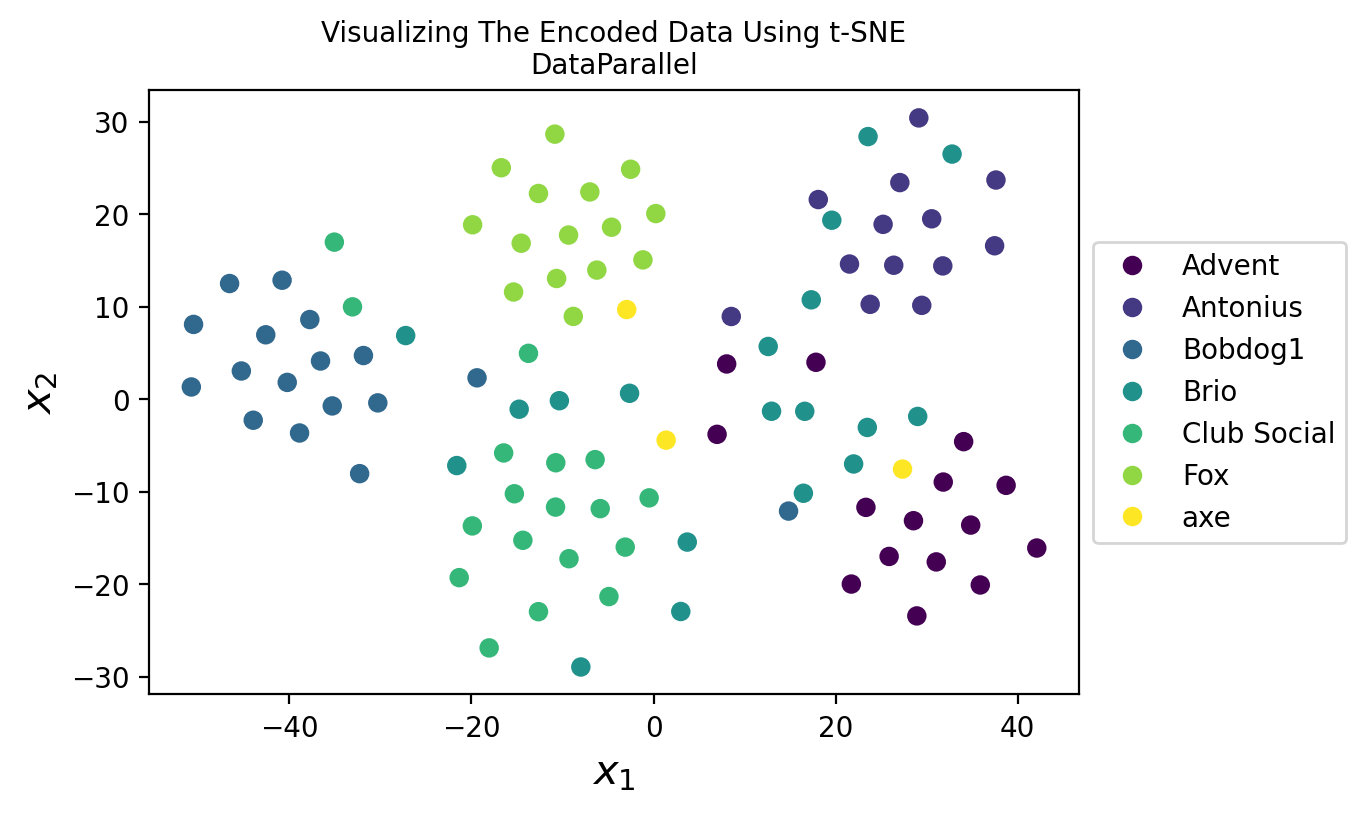

In [17]:
num_epochs = 500
plt.figure(dpi=200)
# plt.scatter(label_new_im[0, 0], label_new_im[0, 1], color="red")
scatter = plt.scatter(embedded_images[:, 0], embedded_images[:, 1], c=labels)
handles, _ = scatter.legend_elements(prop="colors")
plt.legend(handles, dataset.classes, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(
    "Visualizing The Encoded Data Using t-SNE\n{}".format(
        model.__class__.__name__
    ),
    fontsize=10,
)
plt.xlabel("$x_1$", fontsize=15)
plt.ylabel("$x_2$", fontsize=15)
plt.savefig("tsne_vis_{}_{}.jpg".format(model.__class__.__name__, num_epochs))

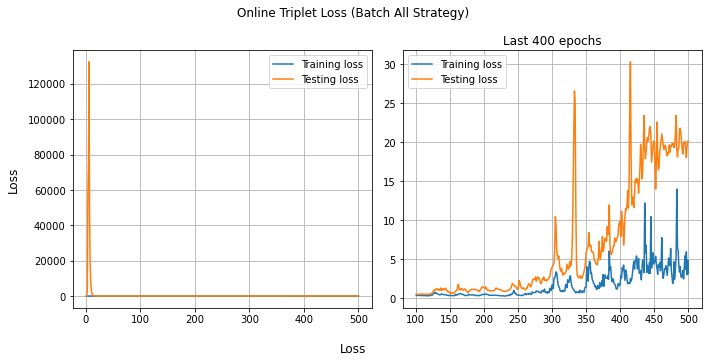

In [12]:
history = checkpoint["loss_history"]
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(10,5))
# axs[0].set_title("All epochs")
axs[0].plot(list(range(1, len(history["train"]) + 1)), history["train"], label="Training loss")
axs[0].plot(list(range(1, len(history["train"]) + 1)), history["test"], label="Testing loss")
axs[0].grid(True)
axs[0].legend()

x = 100
axs[1].set_title("Last {} epochs".format(num_epochs-x))
axs[1].plot(list(range(1, len(history["train"]) + 1))[x:], history["train"][x:], label="Training loss")
axs[1].plot(list(range(1, len(history["train"]) + 1))[x:], history["test"][x:], label="Testing loss")
axs[1].grid(True)
axs[1].legend()

fig.suptitle("Online Triplet Loss (Batch All Strategy)")
fig.supxlabel("Loss")
fig.supylabel("Loss")
plt.tight_layout()
plt.locator_params(axis="x", integer=True, tight=True)
plt.savefig("history_{}_{}.jpg".format(model.__class__.__name__, num_epochs), dpi=300)
# plt.close()